In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
import torchvision.utils as vutils

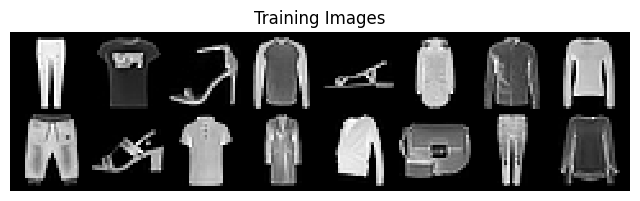

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), interpolation="nearest")

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

## Классический GAN

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        label = torch.ones_like(output)
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        output = discriminator(fake.detach())
        label = torch.ones_like(output) * 0.0
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.15 errD_z: 0.14 errG: 2.13
Epoch:1 Iter: 200 errD_x: 0.17 errD_z: 0.18 errG: 2.38
Epoch:1 Iter: 300 errD_x: 0.13 errD_z: 0.12 errG: 2.48
Epoch:1 Iter: 400 errD_x: 0.17 errD_z: 0.07 errG: 2.94
Epoch:1 Iter: 500 errD_x: 0.12 errD_z: 0.11 errG: 2.74
Epoch:1 Iter: 600 errD_x: 0.05 errD_z: 0.07 errG: 2.98
Epoch:1 Iter: 700 errD_x: 0.02 errD_z: 0.04 errG: 3.38
Epoch:1 Iter: 800 errD_x: 0.05 errD_z: 0.11 errG: 2.50
Epoch:1 Iter: 900 errD_x: 0.19 errD_z: 0.09 errG: 2.60
Epoch:1 Iter: 1000 errD_x: 0.33 errD_z: 0.12 errG: 2.35
Epoch:1 Iter: 1100 errD_x: 0.08 errD_z: 0.15 errG: 2.21
Epoch:1 Iter: 1200 errD_x: 0.11 errD_z: 0.31 errG: 1.74
Epoch:1 Iter: 1300 errD_x: 0.10 errD_z: 0.17 errG: 2.12
Epoch:1 Iter: 1400 errD_x: 0.28 errD_z: 0.12 errG: 2.41
Epoch:1 Iter: 1500 errD_x: 0.15 errD_z: 0.16 errG: 2.27
Epoch:1 Iter: 1600 errD_x: 0.19 errD_z: 0.13 errG: 2.54
Epoch:1 Iter: 1700 errD_x: 0.31 errD_z: 0.11 errG: 2.92
Epoch:1 Iter: 1800 errD_x: 0.10 errD_z: 0.08 errG: 3.25
E

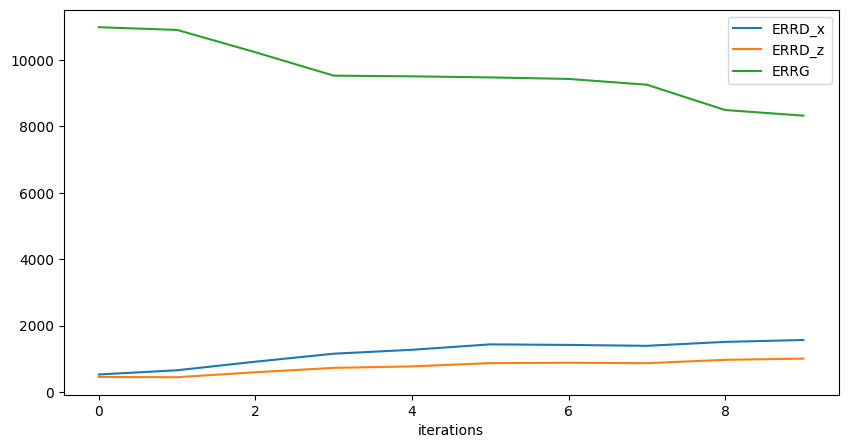

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ERRD_x,label="ERRD_x")
plt.plot(ERRD_z,label="ERRD_z")
plt.plot(ERRG,label="ERRG")

plt.xlabel("iterations")
plt.legend()
plt.show()

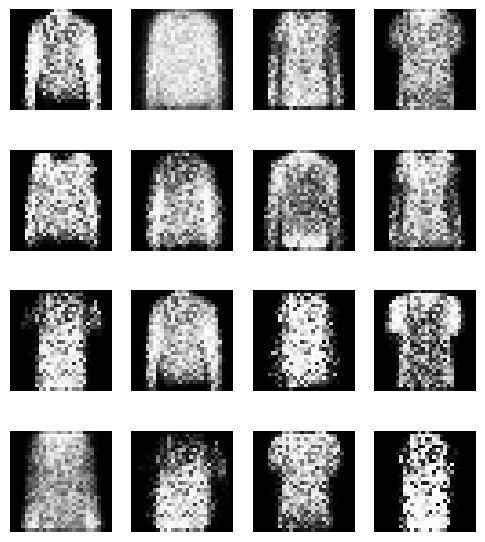

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## WGAN с клиппингом

In [ ]:
generator = Generator()
discriminator = Discriminator()

# optim_G = optim.RMSprop(params=generator.parameters(), alpha=0.00005)
# optim_D = optim.RMSprop(params=discriminator.parameters(), alpha=0.00005)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
def clip_weights(model, clip_value=0.01):
    for p in model.parameters():
        p.data.clamp_(-clip_value, clip_value)


In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
N_CRITIC = 5

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage
        #######
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        errD_x = -torch.mean(discriminator(input_data), dim = 0)
        errD_x.backward()
        ERRD_x[epoch] += errD_x.item()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        errD_z = torch.mean(discriminator(fake.detach()), dim = 0)
        errD_z.backward()
        ERRD_z[epoch] += errD_z.item()

        optim_D.step()
        clip_weights(discriminator)

        #######
        # Generator stage:
        #######
        if iteration % N_CRITIC == 0:
            generator.zero_grad()
            noise.data.normal_(0, 1)
            fake = generator(noise)
            errG = -torch.mean(discriminator(fake), dim = 0)
            errG.backward()
            ERRG[epoch] += errG.item()

            optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: -0.51 errD_z: 0.49 errG: -0.49
Epoch:1 Iter: 200 errD_x: -0.57 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 300 errD_x: -0.61 errD_z: 0.45 errG: -0.45
Epoch:1 Iter: 400 errD_x: -0.59 errD_z: 0.45 errG: -0.45
Epoch:1 Iter: 500 errD_x: -0.59 errD_z: 0.45 errG: -0.46
Epoch:1 Iter: 600 errD_x: -0.57 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 700 errD_x: -0.55 errD_z: 0.47 errG: -0.46
Epoch:1 Iter: 800 errD_x: -0.55 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 900 errD_x: -0.56 errD_z: 0.47 errG: -0.47
Epoch:1 Iter: 1000 errD_x: -0.52 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 1100 errD_x: -0.53 errD_z: 0.47 errG: -0.46
Epoch:1 Iter: 1200 errD_x: -0.51 errD_z: 0.47 errG: -0.46
Epoch:1 Iter: 1300 errD_x: -0.52 errD_z: 0.46 errG: -0.45
Epoch:1 Iter: 1400 errD_x: -0.51 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 1500 errD_x: -0.53 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 1600 errD_x: -0.52 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 1700 errD_x: -0.51 errD_z: 0.46 errG: -0.46
Epoch:1 Iter: 1800 errD

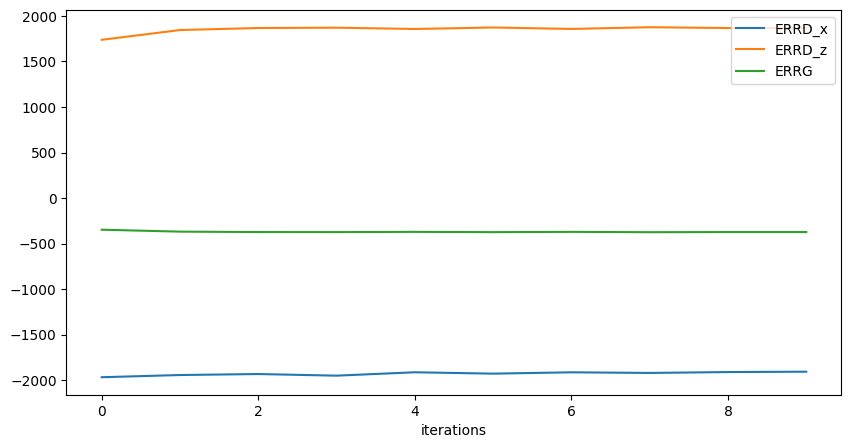

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ERRD_x,label="ERRD_x")
plt.plot(ERRD_z,label="ERRD_z")
plt.plot(ERRG,label="ERRG")

plt.xlabel("iterations")
plt.legend()
plt.show()

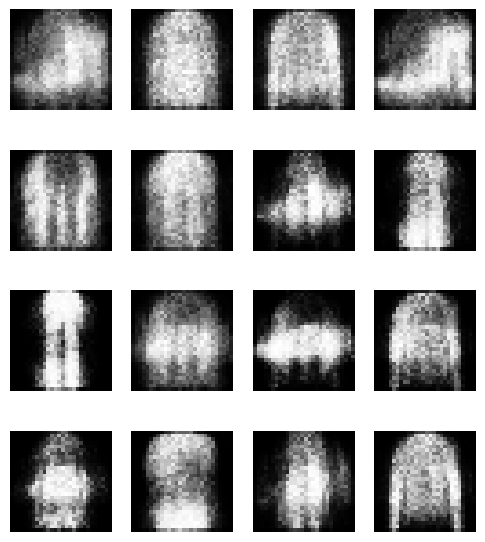

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## WGAN с gradient penalty

In [ ]:
def gradient_penalty(real_data, fake_data, generator, discriminator):
        batch_size = real_data.shape[0]

        alpha = torch.rand(batch_size, 1, 1)
        interpolated = alpha * real_data.data + (1 - alpha) * fake_data.data
        interpolated = Variable(interpolated, requires_grad=True)

        interpolated_probs = discriminator(interpolated)

        gradients = torch.autograd.grad(
            outputs=interpolated_probs,
            inputs=interpolated,
            grad_outputs=torch.ones(interpolated_probs.size()),
            create_graph=True
        )[0]

        gradients = gradients.view(batch_size, -1)

        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        return ((gradients_norm - 1) ** 2).mean()

In [ ]:
generator = Generator()
discriminator = Discriminator()

# optim_G = optim.RMSprop(params=generator.parameters(), alpha=0.00005)
# optim_D = optim.RMSprop(params=discriminator.parameters(), alpha=0.00005)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
LAMBDA = 10

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
ERRD_p = np.zeros(config.num_epochs)
N = len(dataloader)
N_CRITIC = 5

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage
        #######
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        errD_x = -torch.mean(discriminator(input_data), dim = 0)
        errD_x.backward()
        ERRD_x[epoch] += errD_x.item()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        errD_z = torch.mean(discriminator(fake.detach()), dim = 0)
        errD_z.backward()
        ERRD_z[epoch] += errD_z.item()

        # penalty
        errD_p = LAMBDA * gradient_penalty(input_data, fake, generator, discriminator)
        errD_p.backward()
        ERRD_p[epoch] += errD_p.item()

        optim_D.step()

        #######
        # Generator stage:
        #######
        if iteration % N_CRITIC == 0:
            generator.zero_grad()
            noise.data.normal_(0, 1)
            fake = generator(noise)
            errG = -torch.mean(discriminator(fake), dim = 0)
            errG.backward()
            ERRG[epoch] += errG.item()

            optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errD_p: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errD_p.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: -0.58 errD_z: 0.30 errD_p: 0.30 errG: -0.30
Epoch:1 Iter: 200 errD_x: -0.71 errD_z: 0.24 errD_p: 0.12 errG: -0.25
Epoch:1 Iter: 300 errD_x: -0.72 errD_z: 0.25 errD_p: 0.11 errG: -0.21
Epoch:1 Iter: 400 errD_x: -0.79 errD_z: 0.23 errD_p: 0.23 errG: -0.20
Epoch:1 Iter: 500 errD_x: -0.80 errD_z: 0.17 errD_p: 0.32 errG: -0.18
Epoch:1 Iter: 600 errD_x: -0.79 errD_z: 0.19 errD_p: 0.13 errG: -0.19
Epoch:1 Iter: 700 errD_x: -0.70 errD_z: 0.20 errD_p: 0.15 errG: -0.20
Epoch:1 Iter: 800 errD_x: -0.70 errD_z: 0.24 errD_p: 0.06 errG: -0.22
Epoch:1 Iter: 900 errD_x: -0.87 errD_z: 0.18 errD_p: 0.22 errG: -0.22
Epoch:1 Iter: 1000 errD_x: -0.89 errD_z: 0.22 errD_p: 0.51 errG: -0.23
Epoch:1 Iter: 1100 errD_x: -0.85 errD_z: 0.16 errD_p: 0.19 errG: -0.18
Epoch:1 Iter: 1200 errD_x: -0.70 errD_z: 0.19 errD_p: 0.28 errG: -0.24
Epoch:1 Iter: 1300 errD_x: -0.77 errD_z: 0.23 errD_p: 0.16 errG: -0.19
Epoch:1 Iter: 1400 errD_x: -0.80 errD_z: 0.19 errD_p: 0.04 errG: -0.20
Epoch:1 Iter: 1

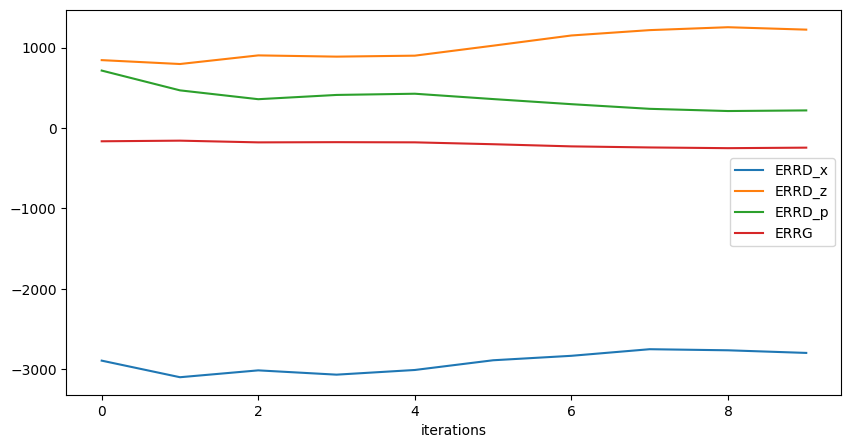

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ERRD_x,label="ERRD_x")
plt.plot(ERRD_z,label="ERRD_z")
plt.plot(ERRD_p,label="ERRD_p")
plt.plot(ERRG,label="ERRG")

plt.xlabel("iterations")
plt.legend()
plt.show()

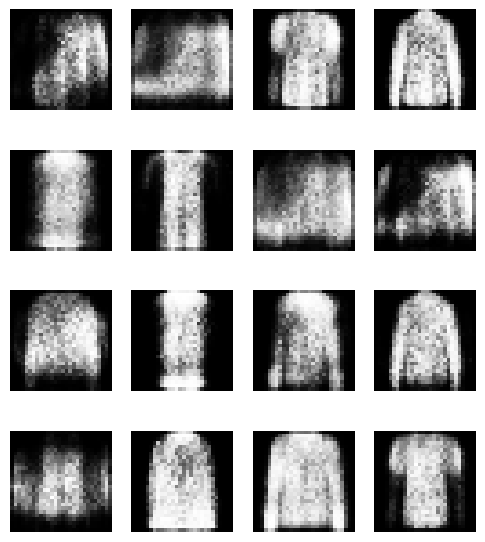

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## Условная генерация

In [ ]:
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x, conditions):
        conditions = nn.functional.one_hot(conditions, num_classes=self.num_classes)
        return self.model(torch.cat([x, conditions], 1))

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = nn.Sequential(
            nn.Linear(28*28+num_classes, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x, conditions):
        conditions = nn.functional.one_hot(conditions, num_classes=self.num_classes)
        return self.model(torch.cat([x, conditions], 1))

In [ ]:
def cond_gradient_penalty(real_data, fake_data, generator, discriminator, cond):
        batch_size = real_data.shape[0]

        alpha = torch.rand(batch_size, 1)
        interpolated = alpha * real_data.data + (1 - alpha) * fake_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        interpolated_probs = discriminator(interpolated,cond)

        gradients = torch.autograd.grad(
            outputs=interpolated_probs,
            inputs=interpolated,
            grad_outputs=torch.ones(interpolated_probs.size()),
            create_graph=True
        )[0]

        gradients = gradients.view(batch_size, -1)

        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        return ((gradients_norm - 1) ** 2).mean()

In [ ]:
generator = ConditionalGenerator(10)
discriminator = ConditionalDiscriminator(10)

# optim_G = optim.RMSprop(params=generator.parameters(), alpha=0.00005)
# optim_D = optim.RMSprop(params=discriminator.parameters(), alpha=0.00005)
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
ERRD_p = np.zeros(config.num_epochs)
N = len(dataloader)
N_CRITIC = 5

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage
        #######
        discriminator.zero_grad()

        # real
        input_data = images.view(images.shape[0], -1)
        errD_x = -torch.mean(discriminator(input_data, cat), dim = 0)
        errD_x.backward()
        ERRD_x[epoch] += errD_x.item()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise,cat)
        errD_z = torch.mean(discriminator(fake.detach(), cat), dim = 0)
        errD_z.backward()
        ERRD_z[epoch] += errD_z.item()

        # penalty
        errD_p = LAMBDA * cond_gradient_penalty(input_data, fake, generator, discriminator, cat)
        errD_p.backward()
        ERRD_p[epoch] += errD_p.item()

        optim_D.step()

        #######
        # Generator stage:
        #######
        if iteration % N_CRITIC == 0:
            generator.zero_grad()
            noise.data.normal_(0, 1)
            fake = generator(noise, cat)
            errG = -torch.mean(discriminator(fake, cat), dim = 0)
            errG.backward()
            ERRG[epoch] += errG.item()

            optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errD_p: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errD_p.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: -0.74 errD_z: 0.27 errD_p: 6.71 errG: -0.27
Epoch:1 Iter: 200 errD_x: -0.62 errD_z: 0.31 errD_p: 3.83 errG: -0.33
Epoch:1 Iter: 300 errD_x: -0.58 errD_z: 0.36 errD_p: 3.46 errG: -0.38
Epoch:1 Iter: 400 errD_x: -0.63 errD_z: 0.46 errD_p: 5.05 errG: -0.43
Epoch:1 Iter: 500 errD_x: -0.60 errD_z: 0.48 errD_p: 4.78 errG: -0.44
Epoch:1 Iter: 600 errD_x: -0.57 errD_z: 0.44 errD_p: 5.73 errG: -0.43
Epoch:1 Iter: 700 errD_x: -0.73 errD_z: 0.45 errD_p: 6.53 errG: -0.46
Epoch:1 Iter: 800 errD_x: -0.71 errD_z: 0.47 errD_p: 6.31 errG: -0.50
Epoch:1 Iter: 900 errD_x: -0.60 errD_z: 0.47 errD_p: 7.58 errG: -0.45
Epoch:1 Iter: 1000 errD_x: -0.76 errD_z: 0.48 errD_p: 7.82 errG: -0.48
Epoch:1 Iter: 1100 errD_x: -0.63 errD_z: 0.50 errD_p: 7.70 errG: -0.47
Epoch:1 Iter: 1200 errD_x: -0.72 errD_z: 0.47 errD_p: 6.66 errG: -0.46
Epoch:1 Iter: 1300 errD_x: -0.73 errD_z: 0.46 errD_p: 5.60 errG: -0.48
Epoch:1 Iter: 1400 errD_x: -0.63 errD_z: 0.50 errD_p: 7.94 errG: -0.47
Epoch:1 Iter: 1

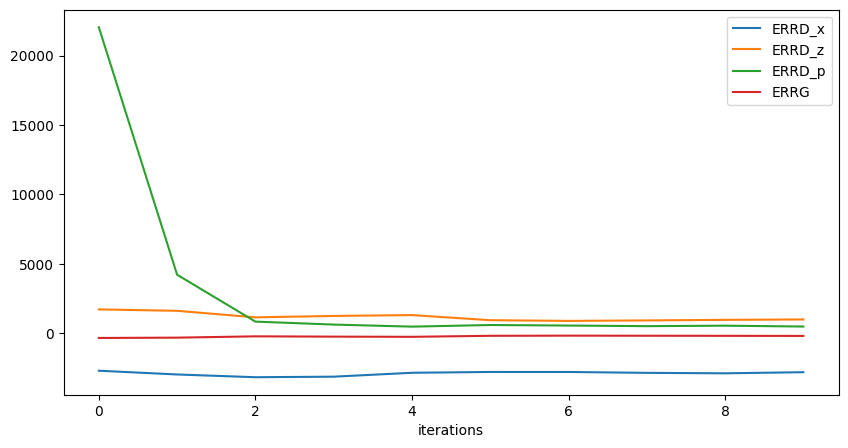

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ERRD_x,label="ERRD_x")
plt.plot(ERRD_z,label="ERRD_z")
plt.plot(ERRD_p,label="ERRD_p")
plt.plot(ERRG,label="ERRG")

plt.xlabel("iterations")
plt.legend()
plt.show()

Класс 0

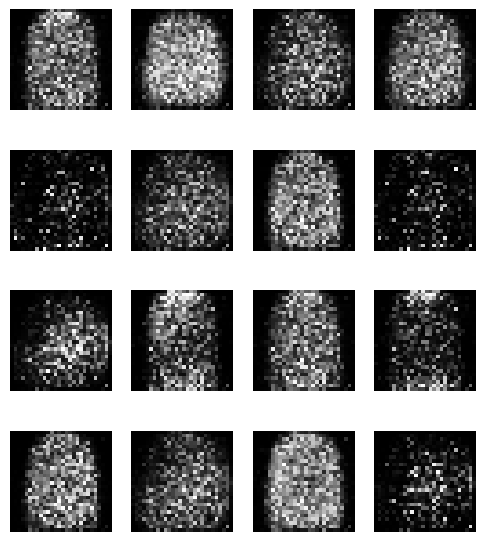

In [ ]:
noise.data.normal_(0, 1)
batch_size = noise.shape[0]
fake = generator(noise,torch.full((batch_size,), 0))

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Класс 1

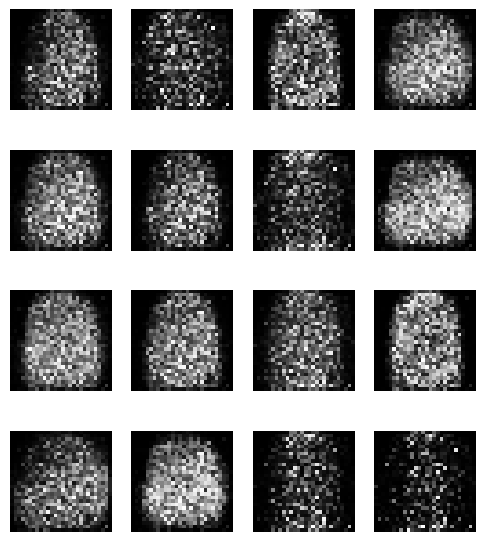

In [ ]:
noise.data.normal_(0, 1)
batch_size = noise.shape[0]
fake = generator(noise,torch.full((batch_size,), 1))

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

**Выводы**

Лоссы мало репрезентабильны, по ним сложно судить о качестве генерации

clipping и gradient penalty показали себя хорошо. Судя по результатам картинки у wgan получились менее зашумленными чем у классического gana. Это можно объяснить более быстрой сходимостью, устойчивостью процесса. Однака безусловный wgan практически всегда генерирует рубашки (и иногда сумки). Результаты conditinal wgan оставляют желать лучшего. Возможно нужно применять другой вариант кодирования условия (а не тривиальный one_hot), либо поменять архитектуру сетей на более подходящие сверточные сети

In [ ]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.ConvTranspose2d(config.noise_size, 16, 7, 1, 0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             # 7x7
#             nn.ConvTranspose2d(16, 8, 4, 2, 1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             #14x14
#             nn.ConvTranspose2d(8, 4, 4, 2, 1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             #28x28
#             nn.ConvTranspose2d(4, 1, 1, 2, 1),
#             nn.Tanh())

#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(28*28, 200),
#             nn.ReLU(inplace=True),
#             nn.Linear(200, 50),
#             nn.ReLU(inplace=True),
#             nn.Linear(50, 1),
#             nn.Sigmoid())
#     def forward(self, x):
#         return self.model(x)